In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import pytz
import ta

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
from datetime import datetime
import MetaTrader5 as mt5

from ortisan_ta.dataaccess import DataItem, MetaTraderDataAccess
import ortisan_ta.utils.analysis as ortisan_ta

from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volume import OnBalanceVolumeIndicator
from ortisan_ta.simulator import MarketSimulator


In [2]:
TOP_50_ASSETS_IBOVESPA = ["ABEV3",
"AZUL4",
"B3SA3",
"BBAS3",
"BBDC4",
"BBSE3",
"BPAC11",
"BRDT3",
"BRFS3",
"BRML3",
"BTOW3",
"CCRO3",
"CIEL3",
"CMIG4",
"COGN3",
"CSNA3",
"CVCB3",
"CYRE3",
"ELET3",
"EQTL3",
"GGBR4",
"GNDI3",
"GOAU4",
"GOLL4",
"IRBR3",
"ITSA4",
"ITUB4",
"JBSS3",
"KLBN11",
"LAME4",
"LREN3",
"MGLU3",
"MRFG3",
"MULT3",
"NTCO3",
"PETR3",
"PETR4",
"PRIO3",
"RADL3",
"RAIL3",
"RENT3",
"SBSP3",
"SULA11",
"SUZB3",
"TOTS3",
"UGPA3",
"USIM5",
"VALE3",
"VVAR3",
"WEGE3"]

### Load data from 1 year

In [6]:
data_access = MetaTraderDataAccess()
dfs = data_access.get_rates_from_symbols(TOP_50_ASSETS_IBOVESPA, datetime(2020, 1, 1), datetime(2021, 1, 1), mt5.TIMEFRAME_D1)
dfs

{'ABEV3':                       Open   High    Low  Close  Spread    Volume
 Date                                                             
 2020-01-01 21:00:00  18.45  18.83  18.37  18.78       1  16411300
 2020-01-02 21:00:00  18.54  18.74  18.48  18.52       1  20059000
 2020-01-05 21:00:00  18.45  18.75  18.28  18.60       1  14644300
 2020-01-06 21:00:00  18.63  18.81  18.45  18.64       1  18036600
 2020-01-07 21:00:00  18.67  18.74  18.45  18.55       1  14051700
 ...                    ...    ...    ...    ...     ...       ...
 2020-12-21 21:00:00  15.50  15.75  15.47  15.51       1  15406100
 2020-12-22 21:00:00  15.58  15.73  15.50  15.50       1  11560800
 2020-12-27 21:00:00  15.57  15.94  15.50  15.77       1  11958000
 2020-12-28 21:00:00  15.90  16.01  15.78  15.95       1  13638800
 2020-12-29 21:00:00  16.05  16.10  15.65  15.65       1  19432700
 
 [249 rows x 6 columns],
 'AZUL4':                       Open   High    Low  Close  Spread    Volume
 Date            

### Calculate return and variance of return we will use then into cluster calculations

In [72]:
dict_closes = {symbol: df.Close for (symbol, df) in dfs.items()}
df_closes = pd.DataFrame.from_dict(dict_closes, orient='columns')
df_closes

,ABEV3,AZUL4,B3SA3,BBAS3,BBDC4,BBSE3,BPAC11,BRDT3,BRFS3,BRML3,...,RENT3,SBSP3,SULA11,SUZB3,TOTS3,UGPA3,USIM5,VALE3,VVAR3,WEGE3
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 21:00:00,18.78,58.80,43.56,52.53,33.30,33.82,74.89,29.57,35.88,18.22,...,49.30,58.87,58.47,40.79,22.88,25.28,9.61,53.07,11.73,34.97
2020-01-02 21:00:00,18.52,56.76,42.30,52.44,33.32,33.44,74.94,29.40,35.94,18.63,...,48.59,57.86,60.84,40.65,23.36,24.98,9.51,52.68,11.48,34.53
2020-01-05 21:00:00,18.60,55.00,41.90,51.74,32.72,33.99,74.06,27.93,35.57,18.50,...,48.02,56.97,60.43,40.58,22.83,24.44,9.33,52.36,11.48,34.62
2020-01-06 21:00:00,18.64,56.82,43.25,51.35,32.15,34.01,74.82,27.89,35.16,18.80,...,48.49,56.00,59.62,41.10,22.93,24.98,9.42,52.74,11.65,34.88
2020-01-07 21:00:00,18.55,56.92,43.14,50.89,31.65,33.99,74.33,27.76,36.51,18.25,...,48.25,55.17,59.41,43.15,22.62,24.79,9.30,52.75,11.60,33.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-21 21:00:00,15.51,35.27,59.76,38.29,26.74,29.16,93.04,22.04,22.22,9.85,...,64.88,43.50,43.15,57.68,27.66,23.35,13.97,86.94,15.94,72.82
2020-12-22 21:00:00,15.50,37.70,59.47,38.92,27.35,29.13,92.23,22.10,22.39,10.01,...,66.60,45.14,43.13,56.37,27.81,23.70,14.62,87.36,16.13,72.62
2020-12-27 21:00:00,15.77,37.77,60.97,39.35,27.62,29.73,94.94,22.16,22.45,10.25,...,66.70,45.71,43.44,57.16,28.13,23.90,14.46,87.31,16.59,75.50


In [105]:
total_return = df_closes.iloc[-1] / df_closes.iloc[0] -1
std = df_closes.std()
adb = pd.DataFrame({"RY": total_return, "SY": std})
adb

,RY,SY
ABEV3,-0.166667,2.002430
AZUL4,-0.331633,14.499833
B3SA3,0.410698,8.664848
BBAS3,-0.261374,7.012544
BBDC4,-0.185586,4.034234
BBSE3,-0.123891,3.061219
BPAC11,0.247697,17.809287
BRDT3,-0.251606,3.468843
BRFS3,-0.385730,5.294262
BRML3,-0.456641,3.320126


In [84]:
portfolio_size = 5

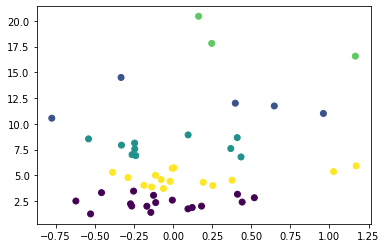

In [90]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=portfolio_size, init='k-means++', n_init=10, random_state=24, max_iter = 300)
pred_y = kmeans.fit_predict(adb)
plt.scatter(adb['RY'], adb["SY"], c = pred_y) #posicionamento dos eixos x e y

In [103]:
adb['Volatile_Reward'] = adb['RY']/adb['SY'] # Maximum return over low volatile
adb['Cluster'] = pred_y
adb.sort_values(by=['Cluster'])

,RY,SY,Cluster,Volatile_Reward
ABEV3,-0.166667,2.002430,0,-0.083232
ITSA4,-0.141288,1.405917,0,-0.100496
JBSS3,-0.110192,2.356635,0,-0.046758
KLBN11,0.412487,3.166812,0,0.130253
COGN3,-0.620492,2.509934,0,-0.247214
CMIG4,0.123137,1.877165,0,0.065597
CIEL3,-0.526627,1.256723,0,-0.419048
CCRO3,-0.263532,2.018931,0,-0.130530
MRFG3,0.442346,2.405866,0,0.183861
BRML3,-0.456641,3.320126,0,-0.137537


In [102]:
portfolio = [adb[adb.Cluster == i].Volatile_Reward.idxmax() for i in range(0, portfolio_size)]
portfolio

['USIM5', 'PRIO3', 'SUZB3', 'WEGE3', 'CSNA3']

### Join all closes into one dataframe. Each column is the symbol

In [7]:
dict_closes = {symbol: df.Close for (symbol, df) in dfs.items()}
df_closes = pd.DataFrame.from_dict(dict_closes, orient='columns')
df_closes.head()

,ABEV3,AZUL4,B3SA3,BBAS3,BBDC4,BBSE3,BPAC11,BRDT3,BRFS3,BRML3,...,RENT3,SBSP3,SULA11,SUZB3,TOTS3,UGPA3,USIM5,VALE3,VVAR3,WEGE3
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 21:00:00,18.78,58.80,43.56,52.53,33.30,33.82,74.89,29.57,35.88,18.22,...,49.30,58.87,58.47,40.79,22.88,25.28,9.61,53.07,11.73,34.97
2020-01-02 21:00:00,18.52,56.76,42.30,52.44,33.32,33.44,74.94,29.40,35.94,18.63,...,48.59,57.86,60.84,40.65,23.36,24.98,9.51,52.68,11.48,34.53
2020-01-05 21:00:00,18.60,55.00,41.90,51.74,32.72,33.99,74.06,27.93,35.57,18.50,...,48.02,56.97,60.43,40.58,22.83,24.44,9.33,52.36,11.48,34.62
2020-01-06 21:00:00,18.64,56.82,43.25,51.35,32.15,34.01,74.82,27.89,35.16,18.80,...,48.49,56.00,59.62,41.10,22.93,24.98,9.42,52.74,11.65,34.88
2020-01-07 21:00:00,18.55,56.92,43.14,50.89,31.65,33.99,74.33,27.76,36.51,18.25,...,48.25,55.17,59.41,43.15,22.62,24.79,9.30,52.75,11.60,33.56


### Calculate correlation between all symbols

In [ ]:
corr = df_closes.corr()

In [ ]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_lowest_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

print("Lowest Absolute Correlations")
print(get_lowest_abs_correlations(corr, 5))